# Essential Dynamics

In [1]:
import os
from dotenv import load_dotenv
import logging
import numpy as np
import pandas as pd
import pickle
import scipy.ndimage
import matplotlib.pyplot as plt
import matplotlib.font_manager
import matplotlib.gridspec as gridspec
import seaborn as sns
from IPython.core.display import display, HTML
import matplotlib.colors as mcolors

from sklearn.decomposition import PCA

logging.basicConfig(level=logging.INFO)
load_dotenv();

<ipython-input-1-b27d2dd69348>:12: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


Matplotlib defaults

In [2]:
def int_linspace(start, stop, num, return_type="list"):
    """
    Returns a set of integers evenly spaced on a linear scale.
    """
    result = set(int(i) for i in np.linspace(start, stop, num))
    if return_type == "set":
        return result
    result = sorted(list(result))
    if return_type == "list":
        return list(result)
    elif return_type == "np":
        return np.array(result)
    else:
        raise ValueError(
            f"return_type must be either 'list' or 'set', got {return_type}"
        )

fonts = set(f.name for f in matplotlib.font_manager.fontManager.ttflist)

sns.set_style("ticks")
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('axes', labelsize=10)
plt.rc('legend', fontsize=10)
plt.rc('axes', titlesize=12)
plt.rcParams['figure.dpi'] = 300

golden_ratio = (5**0.5 - 1) / 2
WIDTH = 3.25
HEIGHT = WIDTH * golden_ratio

In [3]:
def get_nearest_step(steps, step):
        idx = np.argmin(np.abs(np.array(steps) - step))
        return steps[idx]

In [4]:
def osculating_circle(curve, t_index):
    # Handle edge cases
    if t_index == 0:
        t_index = 1
    if t_index == len(curve) - 1:
        t_index = len(curve) - 2

    # Central differences for first and second derivatives
    r_prime = (curve[t_index + 1] - curve[t_index - 1]) / 2
    r_double_prime = (curve[t_index + 1] - 2 * curve[t_index] + curve[t_index - 1])

    # Append a zero for 3D cross product
    r_prime_3d = np.append(r_prime, [0])
    r_double_prime_3d = np.append(r_double_prime, [0])
    
    # Curvature calculation and normal vector direction
    cross_product = np.cross(r_prime_3d, r_double_prime_3d)
    curvature = np.linalg.norm(cross_product) / np.linalg.norm(r_prime)**3
    signed_curvature = np.sign(cross_product[2])  # Sign of z-component of cross product
    radius_of_curvature = 1 / (curvature + 1e-12)
    
    # Unit tangent vector
    tangent = r_prime / np.linalg.norm(r_prime)

    # Unit normal vector, direction depends on the sign of the curvature
    if signed_curvature >= 0:
        norm_perp = np.array([-tangent[1], tangent[0]])  # Rotate tangent by 90 degrees counter-clockwise
    else:
        norm_perp = np.array([tangent[1], -tangent[0]])  # Rotate tangent by 90 degrees clockwise
    
    # Center of the osculating circle
    center = curve[t_index] + radius_of_curvature * norm_perp

    return center, radius_of_curvature

Plot a grid of ED curves, with osculating circles

In [5]:
def plot_essential_dynamics_grid(
    samples,
    steps,
    transitions=None,
    colors=None,
    num_pca_components=3,
    plot_caustic=True,
    figsize=(20, 6),
    marked_cusp_data=None,
    use_cache=False,
    num_sharp_points=20,
    num_vertices=35,
    osculate_start=1,
    osculate_end_offset=0,
    osculate_skip=8,
    smoothing_early=10,
    smoothing_late=60,
    smoothing_boundary=200,
    show_vertex_influence=False,
):
    print(np.shape(samples))
    print(np.shape(samples))
    print(np.shape(samples))
    print(np.shape(samples))
    print(np.shape(samples))
    print(np.shape(samples))
    CUTOFF_START = osculate_start
    CUTOFF_END = osculate_end_offset
    OSCULATE_SKIP = osculate_skip
    sigma_early = smoothing_early
    sigma_late = smoothing_late
    LATE_BOUNDARY = smoothing_boundary
    START_LERP = 0.2 * LATE_BOUNDARY
    END_LERP = LATE_BOUNDARY

    palette = "tab10"
    colors = colors or sns.color_palette(palette)

    num_pca_combos = (num_pca_components * (num_pca_components - 1)) // 2

    fig, axes = plt.subplots(1, num_pca_combos, figsize=figsize)
    if num_pca_combos == 1:
        axes = [axes]


    labels = [""]

    print("Number of samples: " + str(len(samples)))

    #
    # 2D plots
    #

    I = 0

    # Make sure we have the smoothed data for each PC
    smoothed_pcs = []

    for i in range(0, num_pca_components):
        print(f"Processing smoothing for PC{i+1}")
        file_path_smoothings = f"smoothed_pc_i{i}.pkl"
        if use_cache and os.path.exists(file_path_smoothings):
            print("    Using cached smoothing data")
            with open(file_path_smoothings, "rb") as file:
                smoothed_pc = pickle.load(file)
        else:
            smoothed_pc = np.copy(samples[:, :1])
            for z in range(len(samples)):
                if z < START_LERP:
                    sigma = sigma_early
                elif z > END_LERP:
                    sigma = sigma_late
                else:
                    sigma = (sigma_late - sigma_early) / (END_LERP - START_LERP) * (
                        z - START_LERP
                    ) + sigma_early

                smoothed_pc[z, 0] = scipy.ndimage.gaussian_filter1d(
                    samples[:, i], sigma
                )[z]

            with open(file_path_smoothings, "wb") as file:
                pickle.dump(smoothed_pc, file)

        smoothed_pcs.append(smoothed_pc)

    # Make sure we have the osculating data for each pair of PCs

    for i in range(1, num_pca_components):
        for j in range(i):
            # For each PC pair we first do some data processing, then plotting
            print(f"Processing PC{j+1} vs PC{i+1}")

            smoothed_pc_i = smoothed_pcs[i]
            smoothed_pc_j = smoothed_pcs[j]
            smoothed_samples = np.column_stack((smoothed_pc_i, smoothed_pc_j))

            file_path_osculating = f"osculating_data_i{i}_j{j}.pkl"
            if use_cache and os.path.exists(file_path_osculating):
                print("    Using cached osculate data")
                with open(file_path_osculating, "rb") as file:
                    osculating_data = pickle.load(file)
            else:
                osculating_data = {}

                for z in range(CUTOFF_START, len(samples) - CUTOFF_END, 1):
                    osculating_data[z] = osculating_circle(smoothed_samples, z)

                with open(file_path_osculating, "wb") as file:
                    pickle.dump(osculating_data, file)

            radii_list = []
            dcenter_list = []
            dcenter = {}
            radii = {}
            prev_center = None

            for z in range(CUTOFF_START, len(samples) - CUTOFF_END, OSCULATE_SKIP):
                center, radius = osculating_data[z]
                radii[z] = radius
                radii_list.append(radius)
                dcenter[z] = 1000

                if prev_center is not None:
                    d = np.linalg.norm(center - prev_center)
                    dcenter[z] = d
                    dcenter_list.append(d)

                color = "lightgray"
                circle = plt.Circle(
                    (center[0].item(), center[1].item()),
                    radius.item(),
                    alpha=0.5,
                    color=color,
                    lw=0.5,
                    fill=False,
                )

                if I < len(axes):
                    axes[I].add_artist(circle)

                prev_center = center

            # Find high curvature points
            radii_list.sort()
            upper_bound = 0
            if len(radii_list) > num_sharp_points:
                upper_bound = radii_list[num_sharp_points]

            # Find caustic cusps
            dcenter_list.sort()
            dcenter_bound = 0
            if len(dcenter_list) > num_vertices:
                dcenter_bound = dcenter_list[num_vertices]

            # Plot un-smoothed points in the background
            if I < len(axes):
                axes[I].scatter(
                    x=samples[:, i], y=samples[:, j], alpha=0.8, color="lightgray", s=10
                )

            if I < len(axes):
                if transitions:
                    for k, (start, end, stage) in enumerate(transitions):
                        start_idx = steps.index(get_nearest_step(steps, start))
                        end_idx = steps.index(get_nearest_step(steps, end)) + 1

                        axes[I].plot(
                            smoothed_samples[start_idx:end_idx, 0],
                            smoothed_samples[start_idx:end_idx, 1],
                            color=colors[k],
                            lw=2,
                        )
                else:
                    axes[I].plot(samples[:, i], samples[:, j])

            for z in range(CUTOFF_START, len(samples) - CUTOFF_END, OSCULATE_SKIP):
                if (
                    z > 2 * OSCULATE_SKIP
                    and dcenter[z] < dcenter_bound
                    and dcenter[z - OSCULATE_SKIP] < dcenter_bound
                ):
                    print(
                        "    Vertex ["
                        + str(z)
                        + "] rate of change of osculate center "
                        + str(dcenter[z])
                    )
                    if I < len(axes):
                        axes[I].scatter(
                            smoothed_samples[z, 0], smoothed_samples[z, 1], color="gold"
                        )

            # Mark in red high curvature points
            for z in range(CUTOFF_START, len(samples) - CUTOFF_END, OSCULATE_SKIP):
                if radii[z] < upper_bound:
                    print("    Sharp point [" + str(z) + "] curvature " + str(radii[z]))
                    if I < len(axes):
                        axes[I].scatter(
                            smoothed_samples[z, 0], smoothed_samples[z, 1], color="red"
                        )

            if I >= len(axes):
                continue

            current_x_limits = axes[I].get_xlim()
            current_y_limits = axes[I].get_ylim()

            # Draw the evolute
            if plot_caustic:
                for z in range(CUTOFF_START, len(samples) - CUTOFF_END, 1):
                    center, radius = osculating_data[z]

                    if (
                        center[0].item() > current_x_limits[0]
                        and center[0].item() < current_x_limits[1]
                    ):
                        if (
                            center[1].item() > current_y_limits[0]
                            and center[1].item() < current_y_limits[1]
                        ):
                            axes[I].scatter(
                                [center[0].item()],
                                [center[1].item()],
                                color="black",
                                s=0.2,
                            )

            if marked_cusp_data: # TODO
                for marked_cusp_id in range(len(marked_cusp_data)):
                    marked_cusp = marked_cusp_data[marked_cusp_id]["step"]
                    axes[I].scatter(
                        smoothed_samples[marked_cusp, 0],
                        smoothed_samples[marked_cusp, 1],
                        color="green",
                        marker="x",
                        s=40,
                    )
                    center, radius = osculating_data[marked_cusp]
                    axes[I].scatter(
                        [center[0].item()],
                        [center[1].item()],
                        color="green",
                        marker="x",
                        s=60,
                    )

                    if show_vertex_influence:
                        vertex_influence_start = marked_cusp_data[marked_cusp_id][
                            "influence_start"
                        ]
                        vertex_influence_end = marked_cusp_data[marked_cusp_id][
                            "influence_end"
                        ]
                        axes[I].scatter(
                            smoothed_samples[vertex_influence_start, 0],
                            smoothed_samples[vertex_influence_start, 1],
                            color="blue",
                            marker="x",
                            s=40,
                        )
                        axes[I].scatter(
                            smoothed_samples[vertex_influence_end, 0],
                            smoothed_samples[vertex_influence_end, 1],
                            color="blue",
                            marker="x",
                            s=40,
                        )

            axes[I].set_xlabel(f"PC {i+1}")
            axes[I].set_ylabel(f"PC {j+1}")

            I += 1
    axes[0].set_ylabel(f"{labels[0]}\n\nPC 1")

    plt.tight_layout(rect=[0, 0, 1, 1])

    if transitions:
        legend_ax = fig.add_axes(
            [0.1, -0.03, 0.95, 0.05]
        )  # Adjust these values as needed
        handles = [
            plt.Line2D([0], [0], color=colors[i], linestyle="-")
            for i in range(len(transitions))
        ]
        labels = [label for _, _, label in transitions]
        legend_ax.legend(handles, labels, loc="center", ncol=len(labels), frameon=False)
        legend_ax.axis("off")

    fig.set_facecolor("white")

    return fig

## Linear Regression setting

Essential Dynamics for the 50k transformer trained on linear regression. There are five seeds, seed 1 and seed 5 are discussed in the main paper and analysed here.

In [6]:
MODEL_SEED = 1
PLOT_TYPE = 1 

if PLOT_TYPE == 1:
    # To analyse the full run
    steps = int_linspace(0, 500_000, 5_000)
    TRANSITIONS = [
        (0, 1000, 'LR1'),
        (1000, 40_000, 'LR2'),
        (40000, 126000, 'LR3'),
        (126000, 320000, 'LR4'),
        (320000, 500000, 'LR5'),
    ]
elif PLOT_TYPE == 2:
    # To analyse only stage R1 and half of R2
    steps = int_linspace(0, 10_000, 1_00)
    TRANSITIONS = [
        (0, 1500, 'LR1'),
        (1500, 10_000, 'LR2'),
    ]
elif PLOT_TYPE == 3:
    # To analyse only stage R3 and R4
    steps = int_linspace(40_000, 500_000, 4600)
    TRANSITIONS = [
        (40000, 320000, 'LR3'),
        (320000, 500000, 'LR4')
    ]

CLOSEST_TRANSITIONS = [
    (get_nearest_step(steps, t0), get_nearest_step(steps, t1), label) for t0, t1, label in TRANSITIONS
]
print(CLOSEST_TRANSITIONS)
ED_FILENAME = "ED-LR-seed1.pkl"
EVALS_FILENAME = "Evals-LR-seed1.pkl"

# The marked cusps were discovered by the automated vertex discovery and visual inspection,
# while the influence regions are based on analysing the distance functions
marked_cusp_data = [ { "step" : 25, "influence_start" : 18, "influence_end" : 26 },
                #{ "step": 30, "influence_start": 25, "influence_end": 35 },
                { "step" : 345, "influence_start" : 300, "influence_end" : 400 },
                #{ "step" : 1081, "influence_start" : 800, "influence_end" : 1450 },
                { "step" : 1061, "influence_start" : 900, "influence_end" : 1250 },
                { "step" : 1689, "influence_start" : 1500, "influence_end" : 1900 }]
    
with open(ED_FILENAME, "rb") as file:
    pca, samples = pickle.load(file)

# Colours for the LR stages
new_colors=[(1, 0.4980392156862745, 0.05490196078431375),
            (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
            (19/255, 177/255, 235/255),
            (19/255 * 0.6, 177/255 * 0.6, 255/255),
            (0.29411764705882354, 0.29411764705882354, 0.29411764705882354)]

text = ''
for stage, color_rgb in zip(TRANSITIONS, new_colors):
    text = text + f'<span style="background-color: {mcolors.rgb2hex(color_rgb)}; color: black;">{stage[2]} </span>'
    
styled_text = f'<div style="font-family: Arial, sans-serif; font-size: 14px;">{text}</div>'
display(HTML(styled_text))


[(0, 1000, 'LR1'), (1000, 40008, 'LR2'), (40008, 126025, 'LR3'), (126025, 319963, 'LR4'), (319963, 500000, 'LR5')]


Explained variance of PCA
[0.5630448  0.15191932 0.0681259  0.0370252 ]
(5000, 4)
(5000, 4)
(5000, 4)
(5000, 4)
(5000, 4)
(5000, 4)
Number of samples: 5000
Processing smoothing for PC1


Processing smoothing for PC2
Processing smoothing for PC3
Processing PC1 vs PC2
Processing PC1 vs PC3
Processing PC2 vs PC3


<ipython-input-7-81f0bb4e1e47>:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


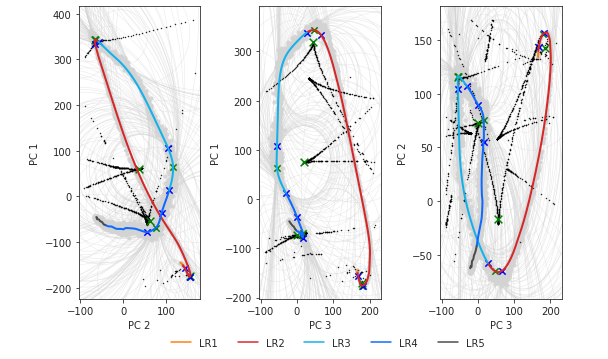

In [7]:
print("Explained variance of PCA")
print(pca.explained_variance_ratio_)

if PLOT_TYPE == 1:
    fig = plot_essential_dynamics_grid(samples, steps, transitions=CLOSEST_TRANSITIONS, colors=new_colors, num_pca_components=3, 
                                    plot_caustic=True, marked_cusp_data=marked_cusp_data, use_cache=False, figsize=(8,8/10 * 6),
                                    num_sharp_points=0, num_vertices=0, osculate_start=1, osculate_end_offset=3000,
                                        osculate_skip=8, smoothing_early=1, smoothing_late=60, smoothing_boundary=200, 
                                        show_vertex_influence=True)        

elif PLOT_TYPE == 2:
    truncated_samples = samples[:100]
    marked_cusp_data = marked_cusp_data[:1]
    fig = plot_essential_dynamics_grid(truncated_samples, steps, transitions=CLOSEST_TRANSITIONS, colors=new_colors, num_pca_components=3, 
                                    plot_caustic=True, marked_cusp_data=None, use_cache=False, figsize=(10,6),
                                    num_sharp_points=0, num_vertices=0, osculate_start=1, osculate_end_offset=2,
                                        osculate_skip=1, smoothing_early=10, smoothing_late=10, smoothing_boundary=200)        
elif PLOT_TYPE == 3:
    truncated_samples = samples[2000:]
    fig = plot_essential_dynamics_grid(truncated_samples, steps, transitions=CLOSEST_TRANSITIONS, colors=new_colors[2:], num_pca_components=3, 
                                    plot_caustic=True, marked_cusp_data=None, use_cache=False, figsize=(10,6),
                                    num_sharp_points=0, num_vertices=0, osculate_start=1, osculate_end_offset=500,
                                        osculate_skip=8, smoothing_early=80, smoothing_late=80, smoothing_boundary=200)        

plt.tight_layout()
plt.show()
fig.savefig("ed_lr_seed1_3pcs.pdf", dpi=300, bbox_inches='tight')

## ED of Brownian motion

Explained variance of PCA
[0.60773704 0.15147447 0.06843747 0.03821073]
(5000, 4)
(5000, 4)
(5000, 4)
(5000, 4)
(5000, 4)
(5000, 4)
Number of samples: 5000
Processing smoothing for PC1
Processing smoothing for PC2
Processing smoothing for PC3
Processing smoothing for PC4
Processing PC1 vs PC2
Processing PC1 vs PC3
Processing PC2 vs PC3
Processing PC1 vs PC4
Processing PC2 vs PC4
Processing PC3 vs PC4


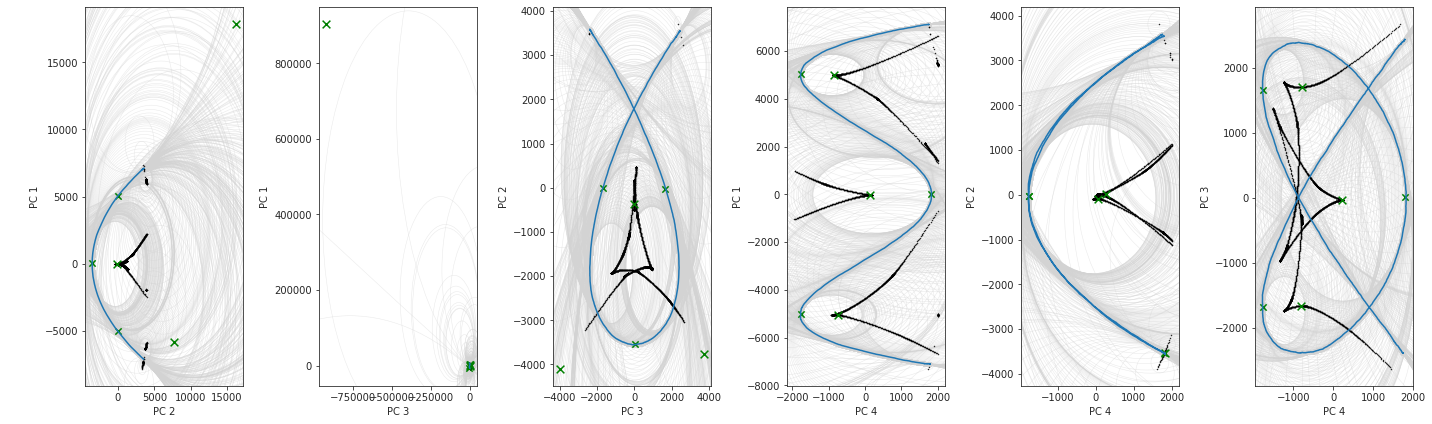

In [8]:
# Brownian Motion Generation Function
def generate_brownian_motion(n=5000, d=10000, sigma=1):
    # Here n is timesteps and d is the dimension of Brownian motion, returns n x d matrix 
    initial_position = np.zeros(d)
    steps = np.random.normal(size=(n-1, d), scale=sigma)
    stacked_steps = np.vstack([initial_position, steps])
    trajectory = np.cumsum(stacked_steps, axis=0)
    return trajectory

# 5000, 50_000
bm_trajectory = generate_brownian_motion(5000,50000)
pca = PCA(n_components = 4)
samples = pca.fit_transform(bm_trajectory) # returns n x n matrix, cols are the principal components, rows are timesteps
print("Explained variance of PCA")
print(pca.explained_variance_ratio_)

marked_cusp_data = [ { "step" : 2500, "influence_start" : 600, "influence_end" : 750 },
                     { "step" : 1250, "influence_start" : 1050, "influence_end" : 1300 },
                     { "step" : 3750, "influence_start" : 2100, "influence_end" : 2300 }]

num_pca_components = 4

fig = plot_essential_dynamics_grid(samples, steps, transitions=None, colors=None, num_pca_components=num_pca_components, 
                                   plot_caustic=True, marked_cusp_data=marked_cusp_data, use_cache=False, figsize=(20,6),
                                   num_sharp_points=0, num_vertices=0, osculate_start=1, osculate_end_offset=0,
                                    osculate_skip=8, smoothing_early=60, smoothing_late=60, smoothing_boundary=300,
                                    show_vertex_influence=False) 

# In the paper
# n = 500, d = 50_000, smoothing 5, explained variance [0.60813083 0.15078717 0.06752149 0.03856071]
# n = 2000, d = 50_000, smoothing 5, explained variance [0.60747183 0.15207123 0.06749039 0.03813415]
# n = 2000, d = 50_000, smoothing 20, explained variance [0.60931725 0.15177815 0.0666105  0.03762016]
# n = 5000, d = 50_000, smoothing 20, explained variance [0.60800557 0.15223367 0.06741403 0.03799418]
# n = 5000, d = 50_000, smoothing 60, explained variance [0.60821546 0.15136478 0.0677885  0.03796959]

Plot the distance in 4D PC space to the midpoint of the trajectory

Processing cusp at 2500


AssertionError: No smoothing stored on disk

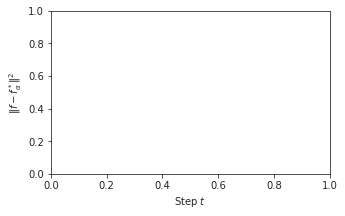

In [9]:
mcd = marked_cusp_data
pc_pairs = [[1,2],[2,3],[1,4]]
num_pca_components = 4
fig = plt.figure(figsize=(5, 3),facecolor='white')
plt.xlabel(r'Step $t$')
plt.ylabel(r'$\Vert f - f^*_{\alpha} \Vert^2$')

marked_cusp = mcd[0]
cusp_index = marked_cusp["step"]
influence_start = marked_cusp["influence_start"]
influence_end = marked_cusp["influence_end"]
sample_indices = np.arange(1,len(samples))

print(f'Processing cusp at {cusp_index}')
center_list = []

for first_pc, second_pc in pc_pairs:
        j = first_pc - 1
        i = second_pc - 1

        file_path_smoothings = f'smoothed_samples_i{i}_j{j}.pkl'
        file_path_osculating = f'osculating_data_i{i}_j{j}.pkl'
        assert os.path.exists(file_path_smoothings), "No smoothing stored on disk"        
        with open(file_path_smoothings, 'rb') as file:
                smoothed_samples = pickle.load(file)

        assert os.path.exists(file_path_osculating), "No osculating data stored to disk"
        with open(file_path_osculating, 'rb') as file:
                osculating_data = pickle.load(file)

        center, radius = osculating_data[cusp_index]
        center_list.append(center)

# center_list[0] = [pc2,pc1]
coeff_pc1 = center_list[0][1]
coeff_pc2 = center_list[0][0]

# center_list[1] = [pc3,pc1]
coeff_pc3 = center_list[1][0]

# center_list[2] = [pc4,pc1]
coeff_pc4 = center_list[2][0]

# pca_vectors[t,:] is the (t+1)st principal component
pca_vectors = pca.components_

f_cusp = pca_vectors[0,:] * coeff_pc1 + pca_vectors[1,:] * coeff_pc2 + pca_vectors[2,:] * coeff_pc3 + pca_vectors[3,:] * coeff_pc4
f_cusp_top = np.array([ coeff_pc1, coeff_pc2, coeff_pc3, coeff_pc4 ])

# Project back for a sanity check
I = 0
for first_pc, second_pc in pc_pairs:
        j = first_pc - 1
        i = second_pc - 1
        
        components_to_use = [i,j]
        selected_components = pca.components_[components_to_use]
        f_projected = f_cusp.dot(selected_components.T)
        print(f'        Norm distance for pair [{first_pc},{second_pc}] is {np.linalg.norm(f_projected - center_list[I])}')
        I += 1
        
distances = np.linalg.norm(samples[sample_indices,:num_pca_components] - f_cusp_top,axis=1)
#distances_2 = np.linalg.norm(samples[sample_indices,:num_pca_components] - samples[2500,:num_pca_components],axis=1)
#distances_3 = np.linalg.norm(samples[sample_indices,:num_pca_components] - samples[2500,:num_pca_components] - np.random.normal(0, 1000, samples[0,:num_pca_components].shape),axis=1)
distances_3 = np.linalg.norm(samples[sample_indices,:num_pca_components] - samples[1250,:num_pca_components],axis=1)
distances_4 = np.linalg.norm(samples[sample_indices,:num_pca_components] - samples[3750,:num_pca_components],axis=1)

distances_to_graph = [distances_3, distances, distances_4]

print(len(distances))
print(f'    Principal components of sample at {cusp_index}:')
print(samples[cusp_index,:4])
print(f'    Principal components of inferred cusp:')
print(f_cusp_top)

alpha = 1
for d in distances_to_graph:
        d = d ** 2
        smoothed_d = scipy.ndimage.gaussian_filter1d(d, 1)
        d = d - np.min(smoothed_d)
        smoothed_d = smoothed_d - np.min(smoothed_d)
        plt.plot(sample_indices[100:], smoothed_d[100:], lw=0.8, label=rf'$\alpha = {alpha}$')
        alpha += 1

plt.legend(loc='lower left')
plt.xscale('log')
plt.show()